# **IBL - Processed Widefield Imaging Data**

This tutorial shows how to access data from <[DANDI:00XXXX](https://dandiarchive.org/dandiset/00XXXX/draft)> for the IBL widefield dataset.

## Study Overview

[TODO add description]

## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [Processed Imaging Data and Metadata](#processed)
4. [Landmarks](#landmarks)
5. [Behavior](#behavior)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [1]:
# Core data manipulation and analysis
# Visualization
import matplotlib.pyplot as plt

# NWB access
from pynwb import read_nwb
from skimage.transform import SimilarityTransform

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Read NWB file from local path

You can read the NWB file from a local path using `pynwb.read_nwb()`.

In [3]:
subject_id = "CSK-im-009"  # Example subject
session_id = "2864dca1-38d8-464c-9777-f6fdfd5e63b5"  # EID for the session

# Read NWB file from local path
nwbfile_path = f"/Volumes/T9/data/IBL/nwbfiles/sub-{subject_id}_ses-{session_id}_desc-processed_ophys+behavior.nwb"
nwbfile = read_nwb(nwbfile_path)

---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [4]:
print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

print("\n=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Strain: {nwbfile.subject.species}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SESSION INFORMATION ===
Experiment description:
 None
Session description:
 A rich text description of the experiment. Can also just be the abstract of the publication.
Session start time:
 2021-07-27 07:25:28.851816-04:00

=== SUBJECT INFORMATION ===
ID: a_subject_id
Age: TBD
Strain: Mus musculus
Genotype: None
Sex: U


---

# 3. Processed Imaging Data and Metadata <a id="processed"></a>

## Temporal components


The SVD temporal components are stored in the `ophys` processing module within the "SVDTemporalComponents" container.

Data shape
- Arrays are shaped `(time, num_components)` — the first dimension is time (frame), the second is the number of components.


Denoised/decomposed series names:
- Calcium (470 nm): `DenoisedSVDTemporalComponentsCalcium`
- Isosbestic (405 nm): `DenoisedSVDTemporalComponentsIsosbestic`
Haemodynamically corrected series name:
- Calcium (470 nm): `HaemoCorrectedSVDTemporalComponentsCalcium`

Access example
```python
SVD_temporal_components = nwbfile.processing["ophys"]["SVDTemporalComponents"]["DenoisedSVDTemporalComponentsCalcium"]
```

In [4]:
print(f"=== SVD Temporal components: ===")
print("-" * 100)
svd_module = nwbfile.processing["ophys"]["SVDTemporalComponents"]
for _, temporal_components in svd_module.roi_response_series.items():
    print(f"Trace: {temporal_components.name}")
    print("-" * 100)
    print(f"   Description: {temporal_components.description}")
    print(f"   Number of ROIs: {temporal_components.data.shape[1]}")
    print(f"   Duration: {temporal_components.timestamps[-1] - temporal_components.timestamps[0]:.2f} seconds")
    print("-" * 100)

=== SVD Temporal components: ===
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Blue light (470 nm) excitation.
   Number of ROIs: 200
   Duration: 4989.12 seconds
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Violet light (405 nm) excitation.
   Number of ROIs: 200
   Duration: 4989.12 seconds
----------------------------------------------------------------------------------------------------
Trace: Ha

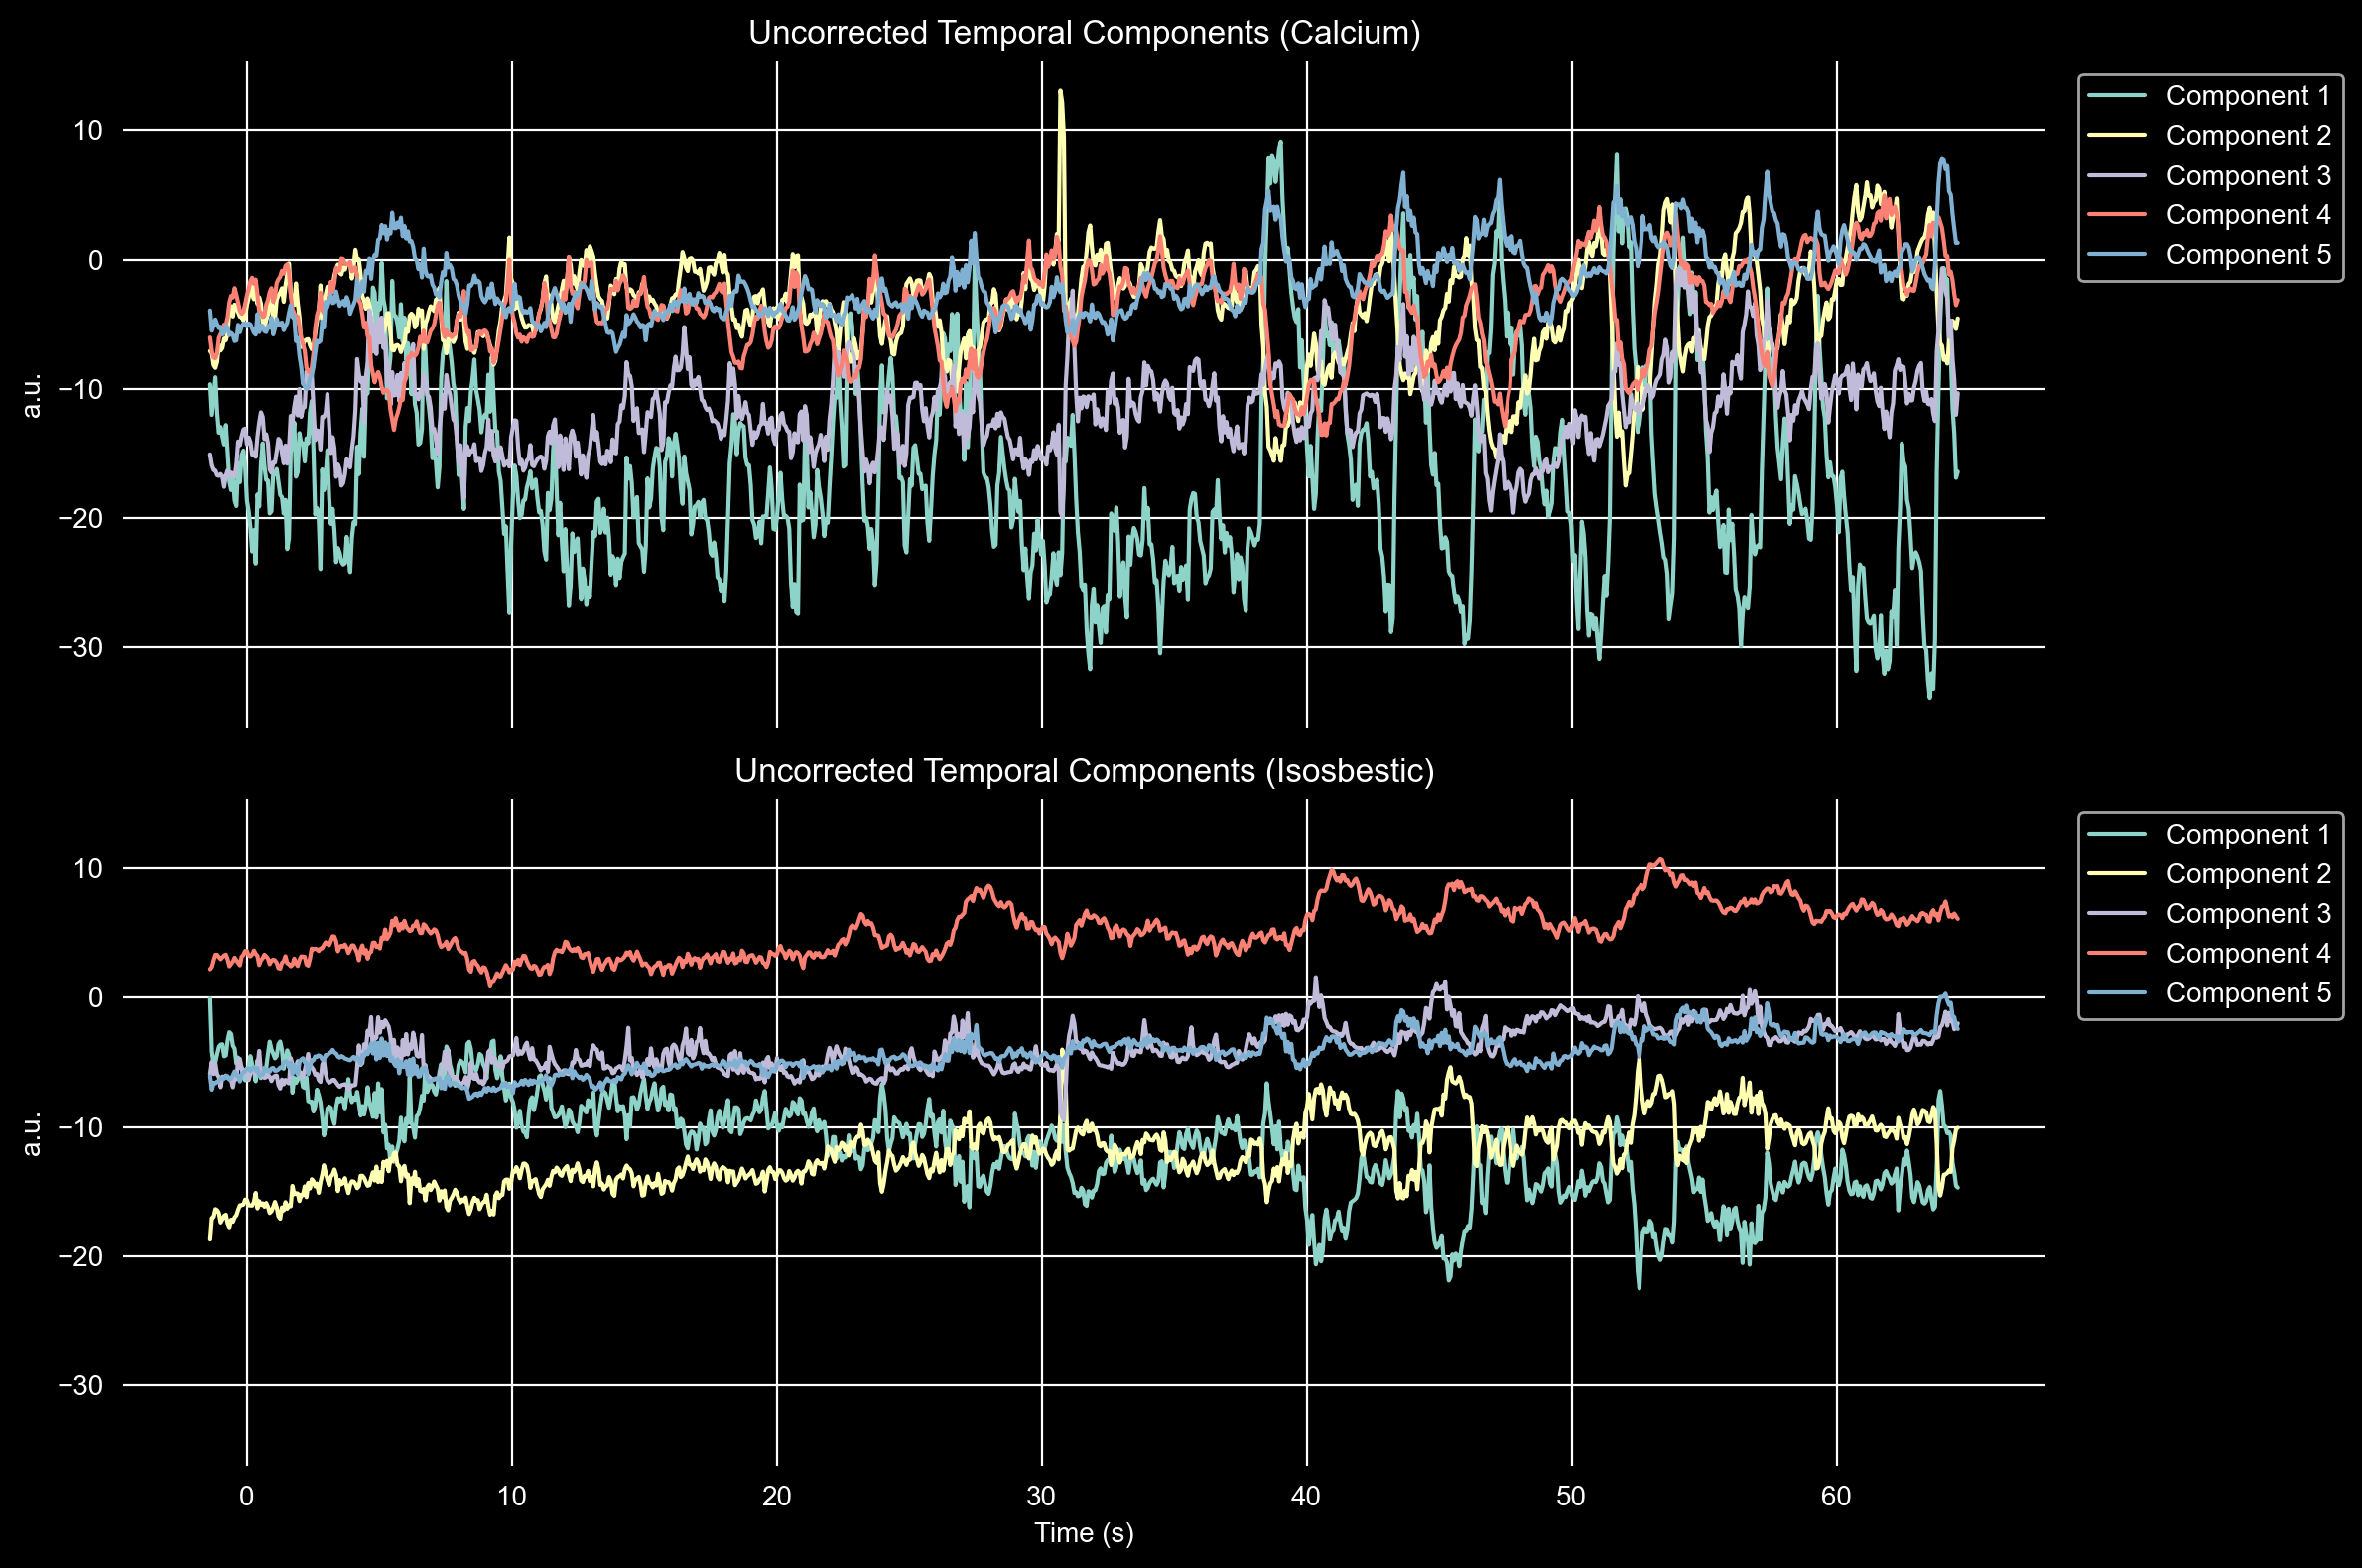

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True, sharey=True)

num_rois = 5
roi_response = svd_module.roi_response_series["DenoisedSVDTemporalComponentsCalcium"]
time = roi_response.timestamps[:1000]  # First 1000 time points
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[0].plot(time, roi_response.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[0].set_title('Uncorrected Temporal Components (Calcium)')
ax[0].set_ylabel('a.u.')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[0].set_frame_on(False)

roi_response_iso = svd_module.roi_response_series["DenoisedSVDTemporalComponentsIsosbestic"]
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[1].plot(time, roi_response_iso.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[1].set_title('Uncorrected Temporal Components (Isosbestic)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('a.u.')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].set_frame_on(False)
plt.tight_layout()

plt.show()

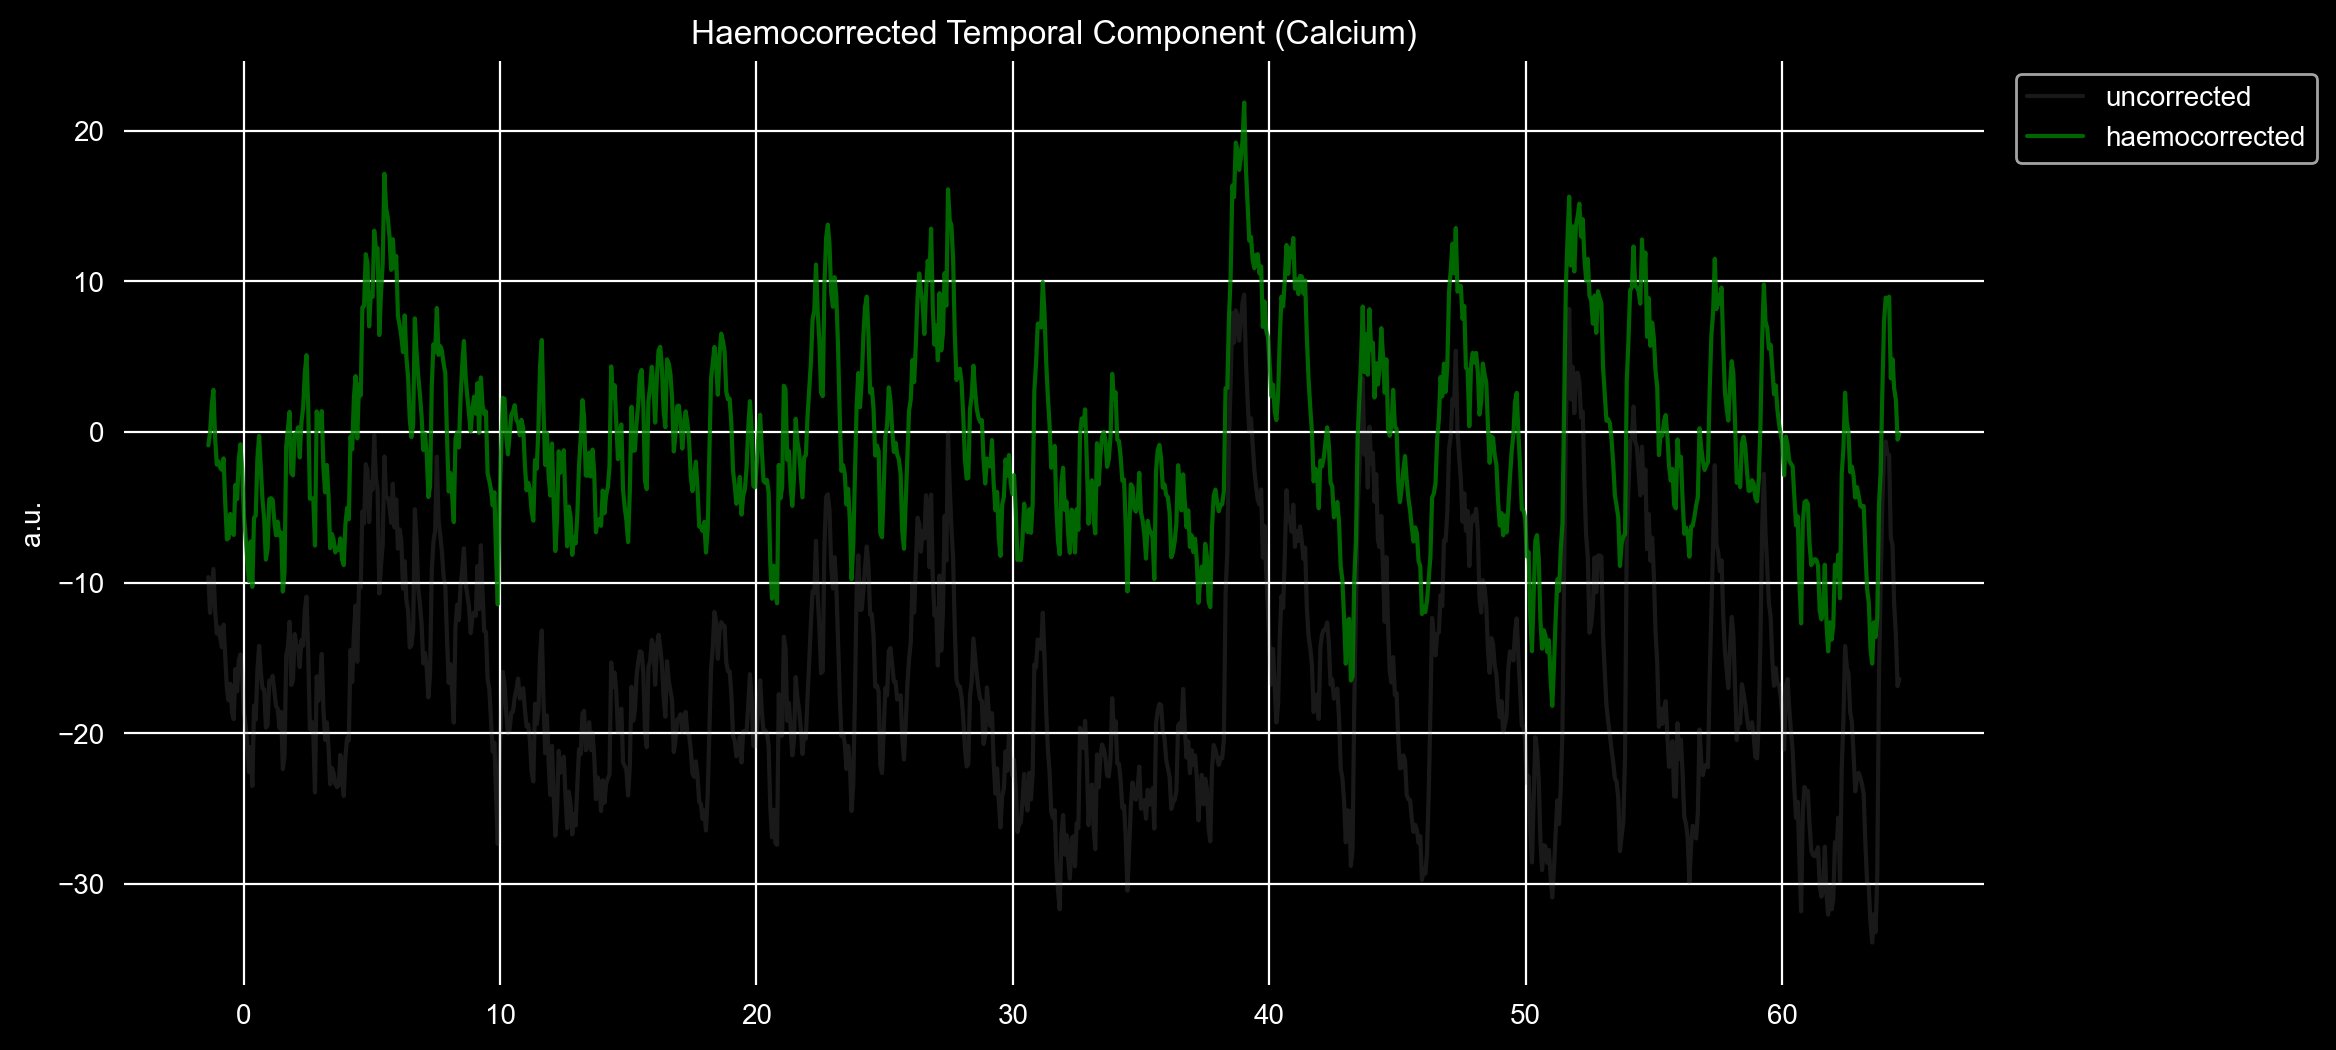

In [6]:
fig, ax = plt.subplots(dpi=200)

roi_response_dff = svd_module["HaemoCorrectedSVDTemporalComponentsCalcium"]
roi_response_raw = svd_module["DenoisedSVDTemporalComponentsCalcium"]

time = roi_response_raw.timestamps[:1000]  # First 1000 time points
ax.plot(time, roi_response_raw.data[:1000, 0], label="uncorrected", color="grey", alpha=0.2)
ax.plot(time, roi_response_dff.data[:1000, 0], label="haemocorrected", color="green", alpha=0.8)
ax.set_title('Haemocorrected Temporal Component (Calcium)')
ax.set_ylabel('a.u.')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_frame_on(False)

plt.show()

The image masks for each field are stored in `PlaneSegmentation` objects in an `ImageSegmentation` container within the "ophys" processing module.

In [7]:
print(f"=== Spatial Components: ===")
print("-" * 100)
spatial_components_module = nwbfile.processing["ophys"]["SVDSpatialComponents"]
for _, plane_segmentation in spatial_components_module.plane_segmentations.items():
    print(f"Plane Segmentation: {plane_segmentation.name}")
    print("-" * 100)
    print(f"   Description: {plane_segmentation.description}")
    print(f"   Linked Imaging Plane: {plane_segmentation.imaging_plane.name}")
    print(f"   ROIs properties: {plane_segmentation.colnames}")
    print("-" * 100)

=== Spatial Components: ===
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneCalcium
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneIsosbestic
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------


In [8]:
plane_segmentation = spatial_components_module["SVDTemporalComponentsCalcium"]
# view plane segmentation table
plane_segmentation.to_dataframe()

roi_name                                         image_mask
id                                                             
0          0  [[0.049625162, 0.04772705, 0.04183665, 0.04222...
1          1  [[0.06113025, 0.059140597, 0.052058227, 0.0520...
2          2  [[-0.0446905, -0.04079102, -0.036529366, -0.04...
3          3  [[0.009191629, 0.007498737, 0.007333804, 0.007...
4          4  [[-0.010197174, -0.009974919, -0.0036508574, -...
..       ...                                                ...
195      195  [[0.030825567, -0.00015199045, -0.011743266, 0...
196      196  [[-0.007716487, 0.0056951162, -0.048174288, 0....
197      197  [[0.011774059, -0.031466763, -0.086726286, -0....
198      198  [[0.003368729, -0.0092208665, -0.02010057, 0.0...
199      199  [[-0.0029760823, -0.029580466, -0.03396571, -0...

[200 rows x 2 columns]

In [9]:
plane_segmentation["image_mask"].shape

(200, 540, 640)

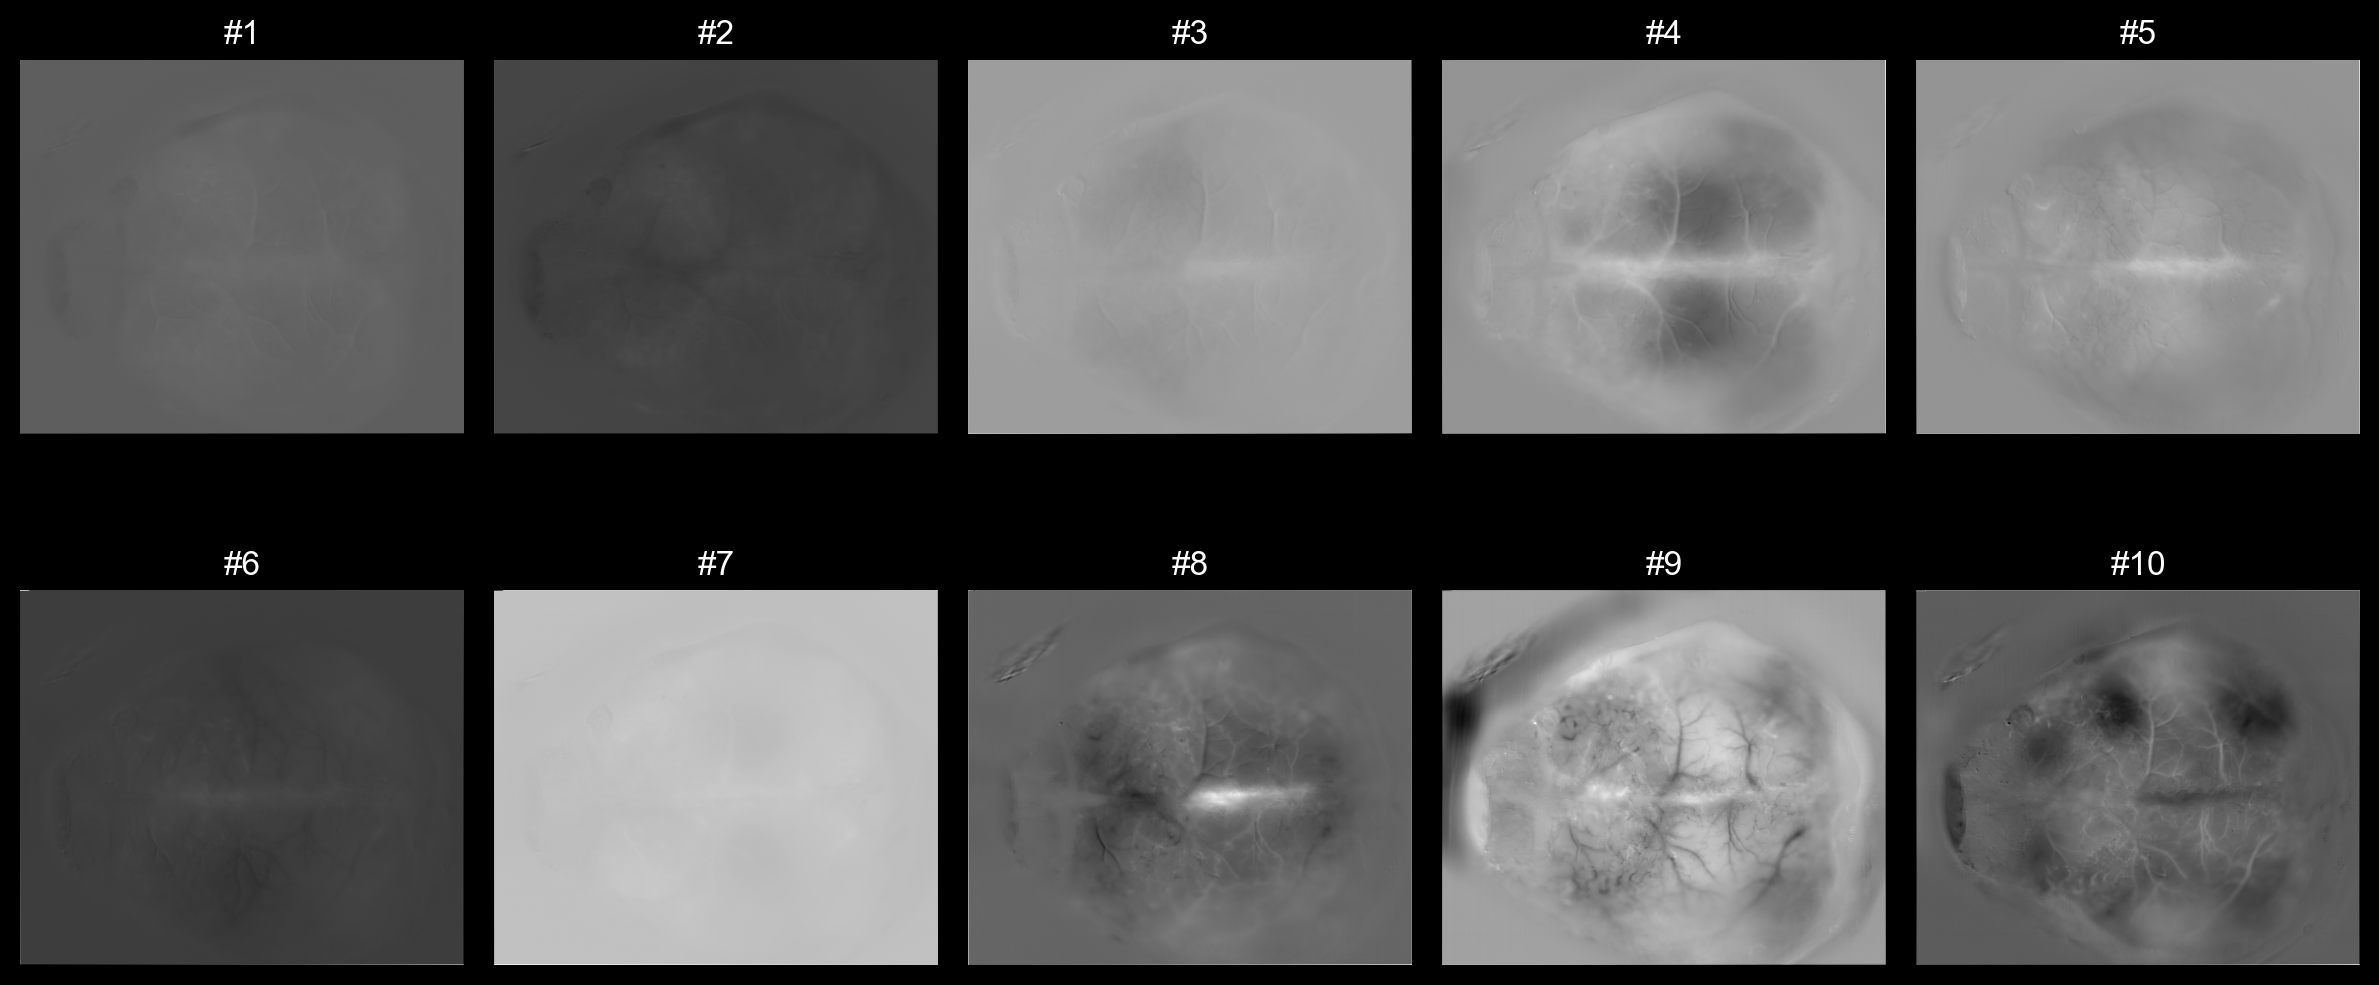

In [10]:
# view example spatial components
roi_ids = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)
for ax, roi_id in zip(axes.flatten(), roi_ids):
    ax.imshow(plane_segmentation["image_mask"][roi_id], cmap="gray")
    ax.set_title(f'#{roi_id + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The summary images are stored in GrayscaleImage objects in an Images container within the "ophys" processing module.


In [11]:
print(f"=== SUMMARY IMAGES: ===")
print("-" * 100)
summary_images = nwbfile.processing["ophys"]["SummaryImages"]
for _, summary_image in summary_images.images.items():
    print(f"Image: {summary_image.name}")
    print("-" * 100)
    print(f"   Description: {summary_image.description}")
    print(f"   Dimensions: {summary_image.data.shape}")
    print("-" * 100)

=== SUMMARY IMAGES: ===
----------------------------------------------------------------------------------------------------
Image: MeanImage
----------------------------------------------------------------------------------------------------
   Description: The mean image under Blue (470 nm) excitation across the imaging session. The dimensions are (height, width).
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------
Image: MeanImageIsosbestic
----------------------------------------------------------------------------------------------------
   Description: The mean image under Violet (405 nm) excitation across the imaging session. The dimensions are (height, width).
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------


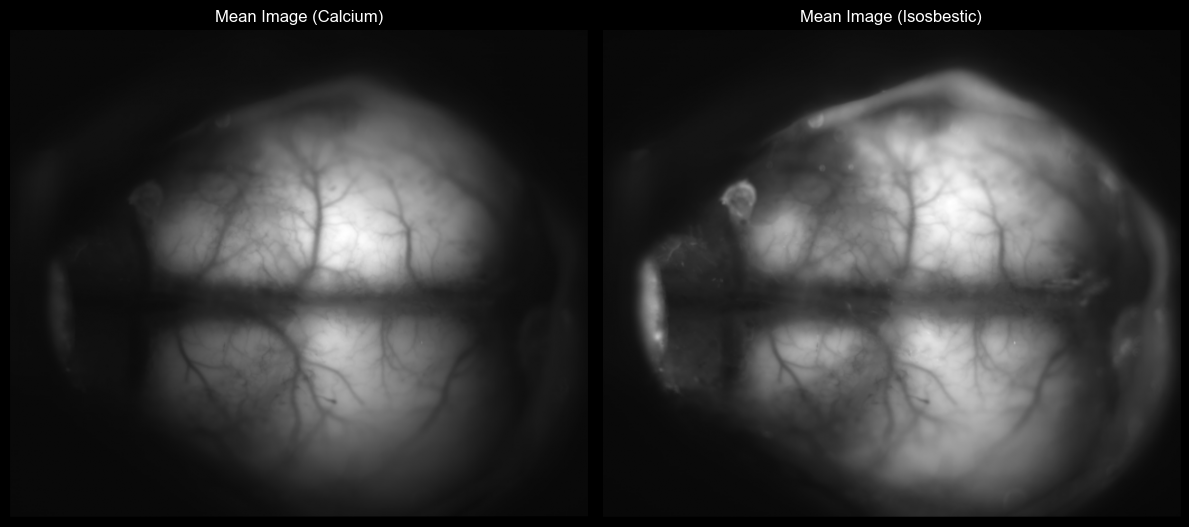

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

mean_image = summary_images.images["MeanImage"]
axes[0].imshow(mean_image, cmap="gray")
axes[0].set_title('Mean Image (Calcium)')
axes[0].axis('off')

mean_image_isosbestic = summary_images.images["MeanImageIsosbestic"]
axes[1].imshow(mean_image_isosbestic, cmap="gray")
axes[1].set_title('Mean Image (Isosbestic)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Aligning data to the Allen reference atlas using Landmarks <a id="landmarks"></a>

The imaging stack can be reconstructed from the decomposed spatial and temporal components of the SVD. The imaging stack contains the imaging data for each frame in the session and has dimensions (time, height, width).

In [13]:
spatial_transformation_metadata = nwbfile.lab_meta_data["SpatialTransformationMetadata"]
spatial_transformation_metadata

SpatialTransformationMetadata abc.SpatialTransformationMetadata at 0x5420149424
Fields:
  landmarks: {
    Landmarks <class 'abc.Landmarks'>
  }
  spatial_transformations: {
    AffineTransformation <class 'abc.AffineTransformation'>
  }

In [14]:
affine_transformation = spatial_transformation_metadata.spatial_transformations["AffineTransformation"]

print("=== Transform ===")
print("-" * 100)
print(f"Source Image: {summary_images.images["MeanImage"].name}")
print("-" * 100)
print(f"   Affine matrix (3x3): ")
for i in range(3):
    print(f"   [{affine_transformation.affine_matrix[i,0]: .4f}  {affine_transformation.affine_matrix[i,1]: .4f} {affine_transformation.affine_matrix[i,2]: .4f}]")


=== Transform ===
----------------------------------------------------------------------------------------------------
Source Image: MeanImage
----------------------------------------------------------------------------------------------------
   Affine matrix (3x3): 
   [-0.0003   0.9756  57.2276]
   [-0.9756  -0.0003  615.2576]
   [ 0.0000   0.0000  1.0000]


In [15]:
landmarks = spatial_transformation_metadata.landmarks["Landmarks"]
landmarks[:]

source_coordinates  \
id                                            
0   [137.33777410662475, 381.4289253365006]   
1    [150.7647955526636, 302.1642844822502]   
2   [140.90343709387514, 226.5938075034403]   
3    [493.5583861297355, 301.8638831489135]   

                         target_coordinates landmark_labels    color  
id                                                                    
0   [219.48453608247422, 92.16494845360825]         OB_left  #fc9d03  
1                [320.0, 92.16494845360825]       OB_center  #0367fc  
2    [420.5154639175258, 92.16494845360825]        OB_right  #fc9d03  
3                [320.0, 434.9484536082474]        RSP_base  #fc4103

In [16]:
nwbfile.processing["ophys"]["CCFAlignedImages"]["CCFAlignedMeanImage"]

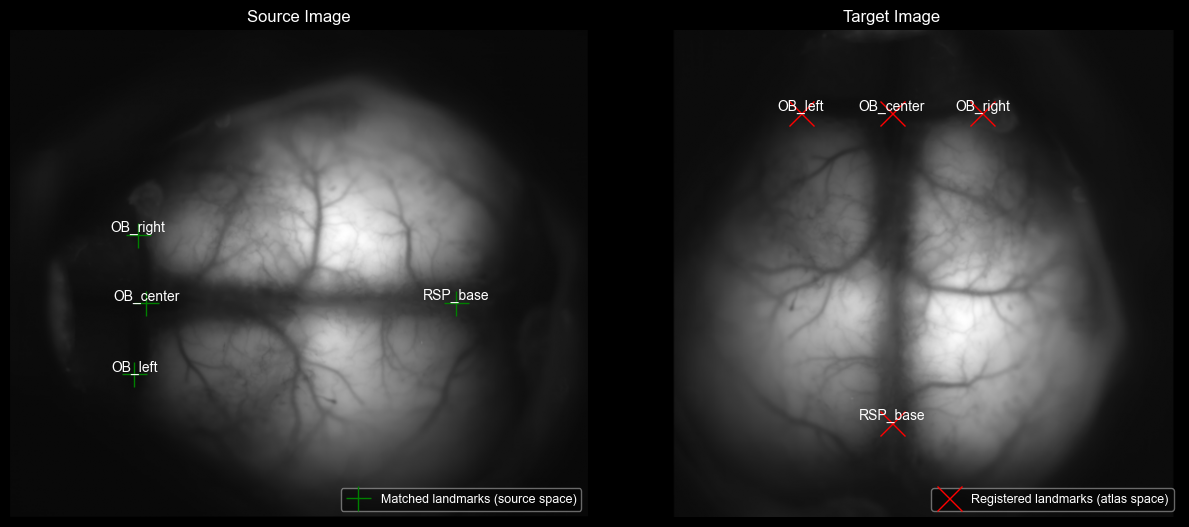

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)


landmarks_df = landmarks[:]
mean_image = summary_images.images["MeanImage"]
mean_image_transformed = nwbfile.processing["ophys"]["CCFAlignedImages"]["CCFAlignedMeanImage"].data[:]

axes[0].imshow(mean_image.data[:], cmap="gray")
axes[0].set_title('Source Image')
axes[0].axis('off')

axes[0].plot(
    landmarks_df["source_coordinates"].apply(lambda v: v[0]),
    landmarks_df["source_coordinates"].apply(lambda v: v[1]),
    "g+",
    ms=18,
    label="Matched landmarks (source space)",
)

# label each source point
for _, row in landmarks_df.iterrows():
    axes[0].text(
        row["source_coordinates"][0],
        row["source_coordinates"][1],
        row["landmark_labels"],
        color="w",
        va="bottom",
        ha="center",
    )

axes[1].imshow(mean_image_transformed, cmap="gray")
axes[1].set_title('Target Image')
axes[1].axis('off')

axes[1].plot(
    landmarks_df["target_coordinates"].apply(lambda v: v[0]),
    landmarks_df["target_coordinates"].apply(lambda v: v[1]),
    "rx",
    ms=18,
    label="Registered landmarks (atlas space)",
)

for _, row in landmarks_df.iterrows():
    axes[1].text(
        row["target_coordinates"][0],
        row["target_coordinates"][1],
        row["landmark_labels"],
        color="w",
        va="bottom",
        ha="center",
    )

# --- Legends and annotation ---
axes[0].legend(loc="lower right", fontsize=9, frameon=True, facecolor="black", framealpha=0.5)
axes[1].legend(loc="lower right", fontsize=9, frameon=True, facecolor="black", framealpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # leave room for subtitle
plt.show()

The imaging stack can be reconstructed from the decomposed spatial and temporal components of the SVD.
The imaging stack contains the imaging data for each frame in the session and has dimensions (nFrames, nx, ny) where nx is the width of the imaging window, and ny the height.

In [18]:
import numpy as np
import wfield

# Spatial components (U):
# plane_segmentation["image_mask"].data has shape: (num_rois, height, width)
U = plane_segmentation["image_mask"].data[:]          # (n_components, height, width)
print(f"Spatial components U shape (n_components, height, width): {U.shape}")

# Haemocorrected temporal components (SVT):
# roi_response_dff.data has shape: (time, num_rois)
SVT = roi_response_dff.data[:]                        # (time, n_components)
print(f"Temporal components SVT shape (time, n_components): {SVT.shape}")

# --- Prepare shapes for SVDStack ---

# wfield.SVDStack expects:
#   U_stack:  (height, width, n_components)
#   SVT_stack: (n_components, time)
U_stack = np.transpose(U, (1, 2, 0))                  # (height, width, n_components)
SVT_stack = SVT.T                                     # (n_components, time)

print(f"U_stack shape (height, width, n_components): {U_stack.shape}")
print(f"SVT_stack shape (n_components, time):         {SVT_stack.shape}")

# --- Build the reconstructed imaging stack ---
# Resulting stack has shape: (time, height, width)
stack = wfield.SVDStack(U_stack, SVT_stack)
print(f"Reconstructed stack shape (time, height, width): {stack.shape}")

Spatial components U shape (n_components, height, width): (200, 540, 640)
Temporal components SVT shape (time, n_components): (75569, 200)
U_stack shape (height, width, n_components): (540, 640, 200)
SVT_stack shape (n_components, time):         (200, 75569)
Reconstructed stack shape (time, height, width): [75569, 540, 640]


In [19]:
# Warp and register the image stack to the Allen dorsal
from skimage.transform import SimilarityTransform

M = SimilarityTransform(affine_transformation.affine_matrix)
stack.set_warped(True, M=M)

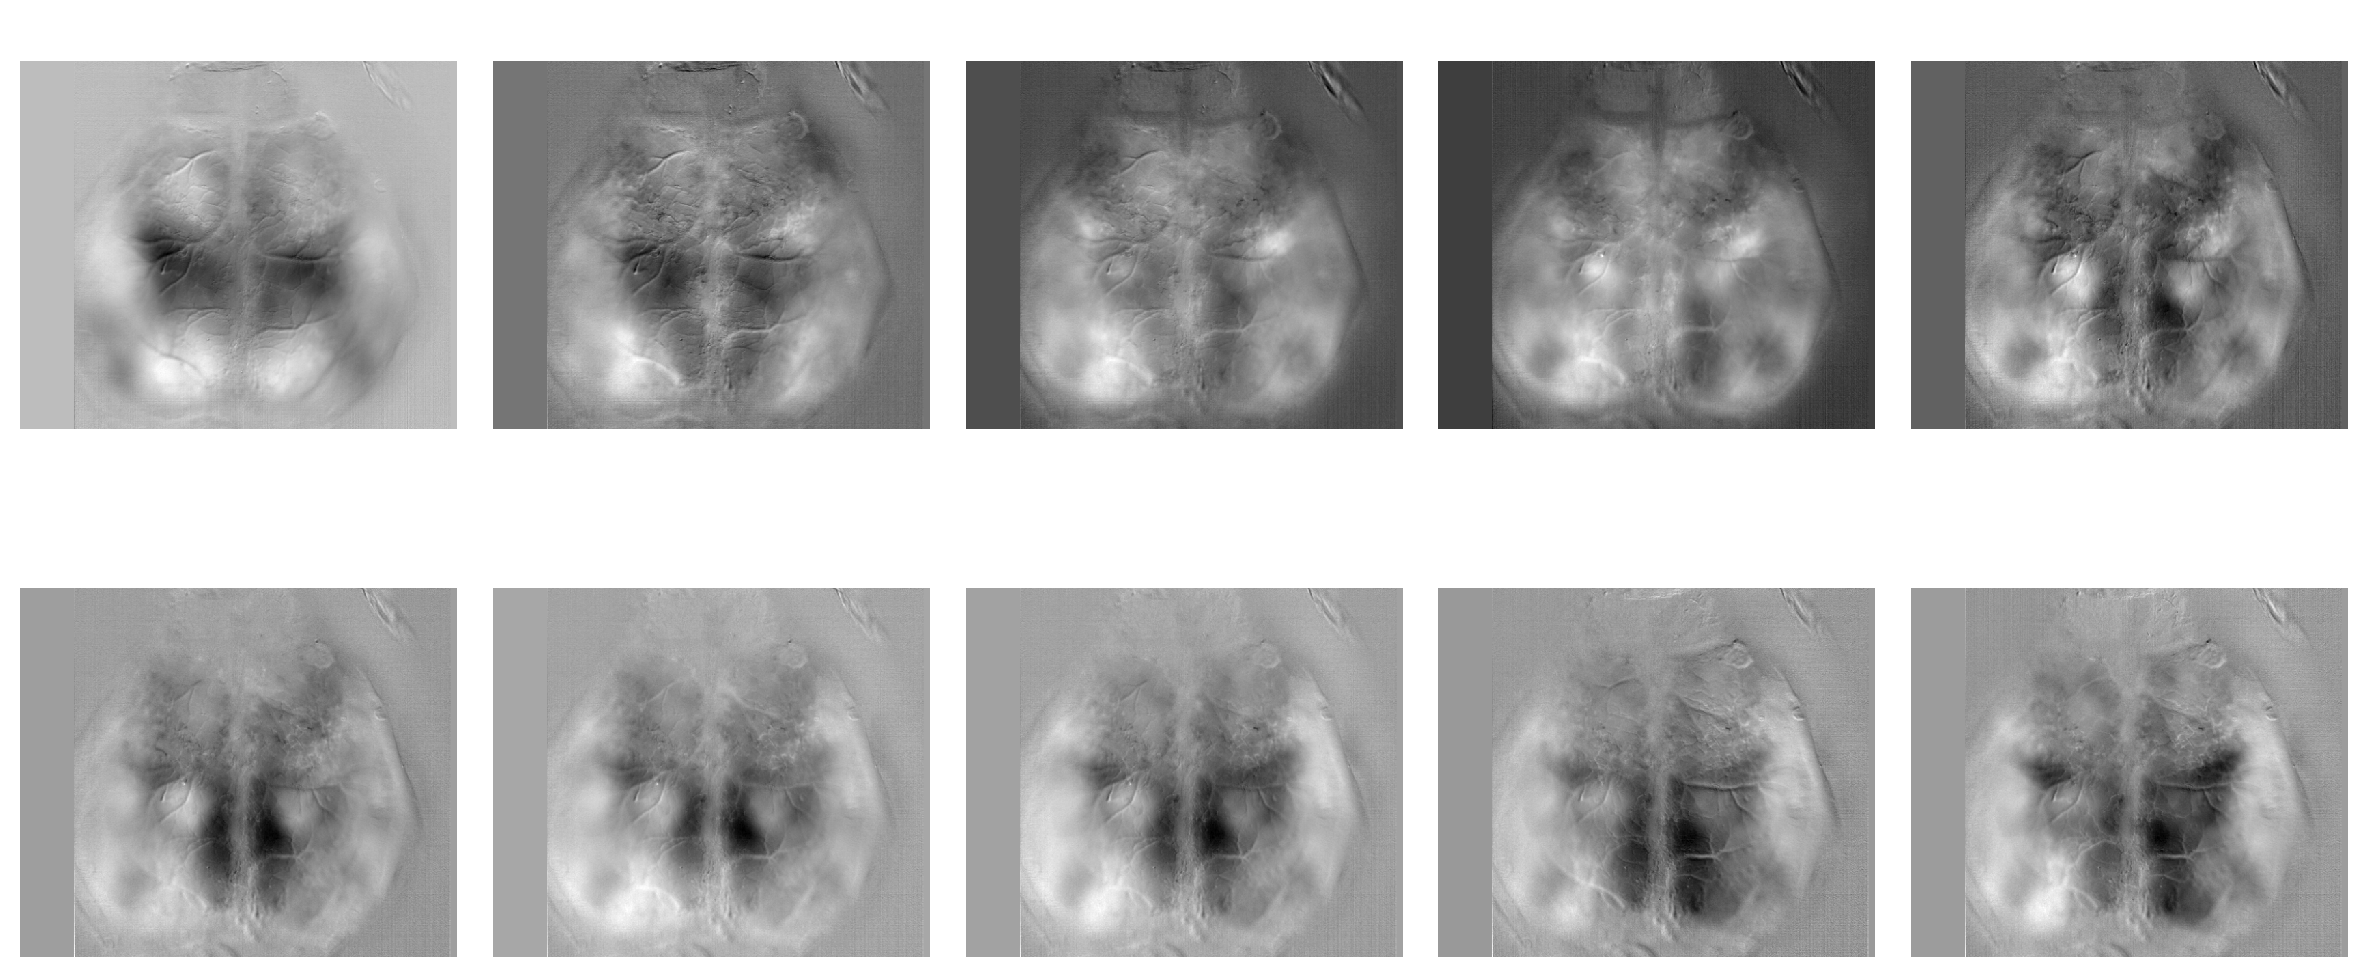

In [20]:
frames = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)

for ax, frame_ind in zip(axes.flatten(), frames):
    ax.imshow(stack[frame_ind], cmap="gray")
    ax.set_title(f"ImageStack#{frame_ind}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()



In [21]:
nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables["CCFLocalization"]

CCFLocalization abc.AnatomicalCoordinatesTable at 0x5420150912
Fields:
  colnames: ['x' 'y' 'z' 'localized_entity' 'resolution' 'bregma_offset'
 'brain_region']
  columns: (
    x <class 'hdmf.common.table.VectorData'>,
    y <class 'hdmf.common.table.VectorData'>,
    z <class 'hdmf.common.table.VectorData'>,
    localized_entity <class 'hdmf.common.table.DynamicTableRegion'>,
    resolution <class 'hdmf.common.table.VectorData'>,
    bregma_offset <class 'hdmf.common.table.VectorData'>,
    brain_region <class 'hdmf.common.table.VectorData'>
  )
  description: Stereotaxic coordinates
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  method: manual annotation
  space: AllenCCFv3 abc.AllenCCFv3Space at 0x5425089232
Fields:
  orientation: ASL
  origin: Dorsal-left-posterior corner of the 3D image volume
  space_name: AllenCCFv3
  units: um

In [22]:
nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables["CCFLocalization"][:]

x       y   z  localized_entity  resolution bregma_offset  \
id                                                                   
0  -1950.0 -3450.0 NaN                 0      0.0194    [320, 270]   
1      0.0 -3450.0 NaN                 1      0.0194    [320, 270]   
2   1950.0 -3450.0 NaN                 2      0.0194    [320, 270]   
3      0.0  3200.0 NaN                 3      0.0194    [320, 270]   

   brain_region  
id               
0       OB_left  
1     OB_center  
2      OB_right  
3      RSP_base

In [23]:
nwbfile.lab_meta_data["localization"].anatomical_coordinates_tables["CCFLocalization"].localized_entity

localized_entity hdmf.common.table.DynamicTableRegion at 0x5425089280
    Target table: Landmarks abc.Landmarks at 0x5424607456

## Behavior <a id="behavior"></a>


### Epochs (Task vs Passive)


In [5]:
nwbfile.epochs

epochs pynwb.epoch.TimeIntervals at 0x5860730656
Fields:
  colnames: ['start_time' 'stop_time' 'protocol_type' 'epoch_description']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    protocol_type <class 'hdmf.common.table.VectorData'>,
    epoch_description <class 'hdmf.common.table.VectorData'>
  )
  description: Session-level epochs defining the two main phases of an IBL recording session. The 'task' epoch covers the active behavioral task period where the mouse performs the decision-making task (responding to visual stimuli by turning a wheel). The 'passive' epoch covers the passive replay period where visual and auditory stimuli are presented without the mouse performing any task, used for receptive field mapping and stimulus response characterization. The passive protocol includes replay of task stimuli, sparse noise for receptive field mapping, and natural movie clips. See the 'protocol_type' column to distinguish between epochs.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

### Trials


In [13]:
trials_df = nwbfile.trials[:]
trials_df[:].head()

start_time  stop_time  quiescence_period  gabor_stimulus_onset_time  \
id                                                                        
0    34.471859  38.257521           0.691901                        NaN   
1    38.659915  41.757385           0.546522                  39.271533   
2    42.148278  46.671291           0.435289                  42.637931   
3    47.078790  50.057393           0.645150                  47.790850   
4    50.477190  54.271119           0.693158                  51.904518   

    auditory_cue_time  wheel_movement_onset_time  choice_registration_time  \
id                                                                           
0                 NaN                        NaN                 36.201441   
1           39.272477                  39.430643                 39.697605   
2           42.639064                  43.372643                 43.615982   
3           47.791699                  47.892643                 47.997291   
4           51.905274                  52.073643                 52.194202   

    feedback_time  gabor_stimulus_offset_time  gabor_stimulus_contrast  \
id                                                                       
0             NaN                         NaN                    25.00   
1       39.697749                   41.257331                    25.00   
2       43.617048                   46.171323                     6.25   
3       47.997397                   49.557357                   100.00   
4       52.194326                   53.770995                    25.00   

   gabor_stimulus_side mouse_wheel_choice  is_mouse_rewarded  \
id                                                             
0                 left              right               True   
1                 left              right               True   
2                right              right              False   
3                 left              right               True   
4                right               left               True   

    reward_volume_uL  probability_left block_type  block_index  
id                                                              
0                1.5               0.5   unbiased            0  
1                1.5               0.5   unbiased            0  
2                0.0               0.5   unbiased            0  
3                1.5               0.5   unbiased            0  
4                1.5               0.5   unbiased            0

### Passive data

In [25]:
passive_module = nwbfile.processing["passive_protocol"]
passive_module

passive_protocol pynwb.base.ProcessingModule at 0x5860681072
Fields:
  data_interfaces: {
    gabor_table <class 'pynwb.epoch.TimeIntervals'>,
    passive_intervals <class 'pynwb.epoch.TimeIntervals'>,
    passive_task_replay <class 'pynwb.epoch.TimeIntervals'>,
    rfm_stim <class 'pynwb.base.TimeSeries'>
  }
  description: Data from the IBL passive stimulus protocol, presented at the end of each recording session while the mouse is disengaged from the task. The protocol consists of three phases: (1) spontaneous activity with no stimuli, (2) receptive field mapping (RFM) using sparse noise visual stimuli, and (3) task replay presenting the same Gabor patches and auditory stimuli (valve, tone, noise) used during the active behavioral task.

In [34]:
passive_module["rfm_stim"]

rfm_stim pynwb.base.TimeSeries at 0x5834331952
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (36000, 15, 15), type "|u1">
  description: receptive field mapping visual stimulus
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (36000,), type "<f8">
  timestamps_unit: seconds
  unit: px

In [26]:
gabor_table = passive_module["gabor_table"]
gabor_table[:]

start_time    stop_time  position  contrast     phase
id                                                         
0    4478.481754  4478.779302     -35.0    0.1250  2.908579
1    4481.265515  4481.562592     -35.0    0.1250  1.032079
2    4483.315222  4483.612488      35.0    0.0625  0.807317
3    4484.948342  4485.262600      35.0    1.0000  2.918300
4    4486.165347  4486.462424      35.0    1.0000  0.509813
..           ...          ...       ...       ...       ...
174  4775.260250  4775.557610      35.0    0.2500  0.949715
175  4777.210082  4777.507630     -35.0    0.2500  2.181048
176  4778.410378  4778.707549     -35.0    0.0625  0.285919
177  4779.426782  4779.724331     -35.0    0.1250  2.119947
178  4781.376803  4781.690778     -35.0    0.0000  1.361347

[179 rows x 5 columns]

In [27]:
passive_intervals = passive_module["passive_intervals"]
passive_intervals[:]

start_time    stop_time        protocol_name
id                                               
0   3782.257941  3842.340190  spontaneousActivity
1   4467.946218  4918.060357           taskReplay

In [29]:
passive_task_replay = passive_module["passive_task_replay"]
passive_task_replay

passive_task_replay pynwb.epoch.TimeIntervals at 0x5834332288
Fields:
  colnames: ['start_time' 'stop_time' 'stim_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    stim_type <class 'hdmf.common.table.VectorData'>
  )
  description: Passive stimulation events including valve, tone, and noise stimuli.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

### ROI Motion Energy

In [30]:
print("=== VIDEO PROCESSING MODULE ===\n")
motion_energy_series = []
for name, proc in nwbfile.processing["video"].items():
    if "MotionEnergy" not in name:
        continue
    print("-" * 100)
    print(f"{name} - {proc.description}: ")
    print("-" * 100)
    motion_energy_series.append(name)

=== VIDEO PROCESSING MODULE ===

----------------------------------------------------------------------------------------------------
TimeSeriesBodyMotionEnergy - Motion energy calculated for a region of the body camera video that is 201 pixels wide, 210 pixels tall, and the top-left corner of the region is the pixel (134, 127).

CAUTION: As each software will load the video in a different orientation, the ROI might need to be adapted. For example, when loading the video with cv2 in Python, x and y axes are flipped from the convention used above. The region then becomes [127:337, 134:335].: 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TimeSeriesLeftMotionEnergy - Motion energy calculated for a region of the left camera video that is 174 pixels wide, 116 pixels tall, and the top-left corner of the region is the pixel (310, 145).

C

### Wheel

In [32]:
print("=== WHEEL PROCESSING MODULE ===\n")
motion_energy_series = []
for name, proc in nwbfile.processing["wheel"].items():
    if "CompassDirection" in name:
        print("-" * 100)
        print(f"{name}: ")
        print("-" * 100)
        for ss_name, ss in proc.spatial_series.items():
            print(f"\t{ss_name} - {ss.description}")
    elif "Intervals" in name:
        print("-" * 100)
        print(f"{name} - {proc.description}: ")
        display(proc.to_dataframe().head(5))  # Display first 5 rows
        print("-" * 100)
    else:
        print("-" * 100)
        print(f"{name} - {proc.description}: ")
        print("-" * 100)
        motion_energy_series.append(name)

=== WHEEL PROCESSING MODULE ===

----------------------------------------------------------------------------------------------------
SpatialSeriesWheelPosition - Absolute unwrapped angle of the wheel from session start. The sign from the subject perspective corresponds to mathematical convention; counter-clockwise is positive. The wheel diameter is 6.2 cm and the number of ticks is 4096 per revolution.
: 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TimeSeriesWheelAcceleration - The acceleration estimated from the position interpolated at a frequency of 1000 Hz and passed through an 8th order lowpass Butterworth filter.: 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TimeSeries

start_time  stop_time  peak_amplitude
id                                       
0     0.193643   0.251643        0.013064
1     1.473643   1.527643        0.014851
2     8.771643   9.519643       -0.433891
3    15.098643  17.356643       -0.128446
4    18.059643  18.172643        0.090898

----------------------------------------------------------------------------------------------------
